In [1]:
import os
import re
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from wordcloud import WordCloud, ImageColorGenerator

import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mauricio.jesus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from src.sentenceregbr import SentenceRegBr
objSentecesRegBr = SentenceRegBr()

  Abbreviation: [1.5213] art
  Abbreviation: [0.6892] nr
  Abbreviation: [0.4181] n
  Abbreviation: [0.6892] sr
  Abbreviation: [1.1977] sr
  Abbreviation: [1.1977] nr
  Abbreviation: [0.4406] sra
  Abbreviation: [1.5421] art
  Abbreviation: [1.5797] n
  Abbreviation: [0.5989] ms


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mauricio.jesus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/mauricio.jesus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from src.preprocessing import PreProcessing
objPreProcessing = PreProcessing()

In [5]:
BASE_DIR = Path(os.path.abspath('')).resolve()

### Get Dataset


In [6]:
dfTreino = pd.read_excel(Path(os.path.join(BASE_DIR,'dataset', 'train_test_val','df_train_12092022_v2.xlsx')))
dfTest = pd.read_excel(Path(os.path.join(BASE_DIR,'dataset', 'train_test_val','df_test_12092022_v2.xlsx')))

dfTreino = pd.concat([dfTreino,dfTest])
dfTreino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6746 entries, 0 to 271
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6746 non-null   int64 
 1   cat     6746 non-null   int64 
 2   text    6746 non-null   object
 3   versao  6746 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 263.5+ KB


In [7]:
dfTreino[["cat"]].value_counts()

cat
0      6183
1       562
3         1
dtype: int64

In [8]:
dfTreino.head(10)

,id,cat,text,versao
0,1,0,iii o excesso ou insuficiência das origens de ...,1
1,2,0,a concessão de pensão aos beneficiários de que...,1
2,3,0,alteração de estrutura de carreira que impliqu...,1
3,4,0,os peritos ou a empresa avaliadora deverão apr...,1
4,5,0,os aeródromos públicos poderão ser usados por ...,1
5,6,0,a apuração do tempo de serviço será feita em d...,1
6,7,0,o os servidores beneficiados pelos afastamento...,1
7,8,0,caso a pessoa jurídica prejudicada não adote a...,1
8,9,0,a despesa total com pessoal será apurada soman...,1
9,10,0,a execução orçamentária e financeira identific...,1


In [9]:
dfTreinoTerceiroSetor = dfTreino[dfTreino["cat"]==1].copy()
txtListTercSetor = dfTreinoTerceiroSetor["text"].to_list()

##Drop None
txtListTercSetor = [x for x in txtListTercSetor if x is not None]
AllTxtTercSetor = " ".join(str(s).lower() for s in txtListTercSetor)
AllTxtTercSetor = objPreProcessing.clearNumerosRomanos(AllTxtTercSetor)

In [11]:
AllTxtTercSetor = " ".join(s for s in AllTxtTercSetor)

In [12]:
stopwords = stopwords + ["art", "deste", "outro", "art", "artigo","n","nr","desta","deste","ainda","caso"]
text_tokens = word_tokenize(AllTxtTercSetor)
tokens_without_sw = [word for word in text_tokens if not word in stopwords]
AllTxtTercSetor = " ".join(s for s in tokens_without_sw)

In [16]:
# gerar uma wordcloud
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=2600, height=1800).generate(AllTxtTercSetor)

# mostrar a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)
wordcloud.to_file("terc_setor_wordcloud.png")


' # gerar uma wordcloud\nwordcloud = WordCloud(stopwords=stopwords,\n                      background_color="white",\n                      width=2600, height=1800).generate(AllTxtTercSetor)\n\n# mostrar a imagem final\nfig, ax = plt.subplots(figsize=(10,6))\nax.imshow(wordcloud, interpolation=\'bilinear\')\nax.set_axis_off()\nplt.imshow(wordcloud)\n#wordcloud.to_file("terc_setor_wordcloud.png")\n'

### Building document dataset

In [14]:
listaDfDocs = []
nrDocuments = 2500

In [9]:
def gerarDocumentos(df,pNrDocs,pListaDfDocs):
    
    dfTservTmp = df.copy()
        
    ##Gerar docs
    for i in range(0,pNrDocs):
        
        maxIteration = 10
        totalToken = 0
        nrIteration = 0
        maxTokensDocs = 512
        dfText = pd.DataFrame()
        
        while totalToken < maxTokensDocs and len(dfTservTmp) > 0:
            
            dfSample = dfTservTmp.sample(replace=False)
            
            ##Remove sampled
            dfTservTmp = dfTservTmp[dfTservTmp.index != dfSample.index[0]]
            dfSample_tokens_total = dfSample["tokens_no_stopwords"].iloc[0]
            dfText = pd.concat([dfText,dfSample])
            
            totalToken = totalToken + dfSample_tokens_total

            if(nrIteration > maxIteration):
                break
            
            nrIteration = nrIteration + 1

        pListaDfDocs.append(dfText)
        
        if len(dfTservTmp) < 1:
            dfTservTmp = df.copy()
            
    return pListaDfDocs

##### Third Sector document dataset

In [10]:
listaDfDocs = gerarDocumentos(dfTS,nrDocuments,listaDfDocs)

In [11]:
len(listaDfDocs)

2500

##### Building initial data analysis.

In [12]:
listaIdDocBase = []
listaIdSentenca = []
for dfTextProc in listaDfDocs:
    for index,row in dfTextProc.iterrows():
        listaIdDocBase.append(row["id_doc_base"])
        listaIdSentenca.append(row["id_sentenca"])
        

In [21]:
countDocBase = [[x,listaIdDocBase.count(x)] for x in set(listaIdDocBase)]
countSentenca = [[x,listaIdSentenca.count(x)] for x in set(listaIdSentenca)]

<AxesSubplot:ylabel='Count'>

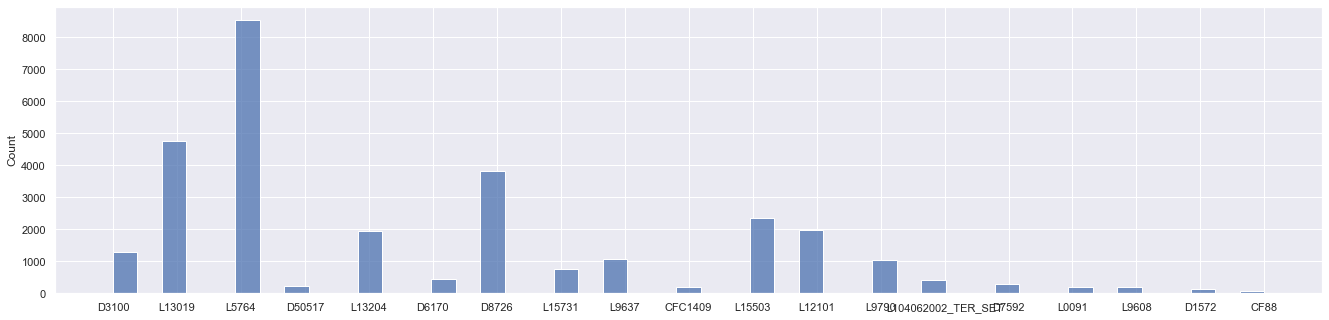

In [22]:
sns.set(rc={'figure.figsize':(22.7,5.27)})
sns.histplot(data=listaIdDocBase, discrete=False)

<AxesSubplot:ylabel='Count'>

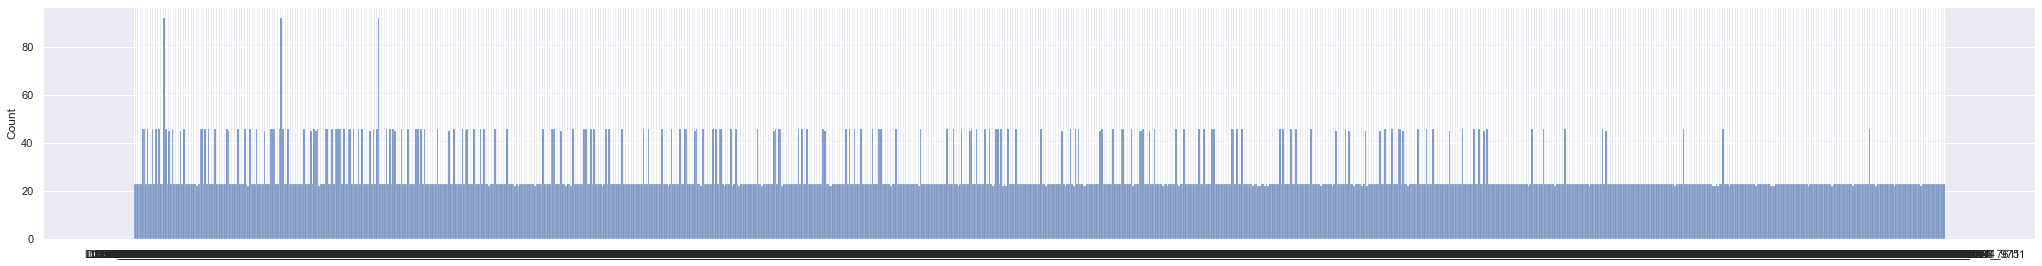

In [23]:
sns.set(rc={'figure.figsize':(35.7,4.27)})
sns.histplot(data=listaIdSentenca, discrete=True)

##### Setting dfTraning with third sector document dataset

In [13]:
dfTreino = pd.DataFrame()

for dfTextProc in listaDfDocs:
    txtList = dfTextProc["text_sentenca"].to_list()

    ##Drop None
    txtList = [x for x in txtList if x is not None]
    
    try:
        txt = ' '.join(txtList)
    except Exception as e:
        print(e, txtList)

    reg = {  "cat":"terceiro_setor"
            ,"text":txt
        }
        
    dfTreino = pd.concat([dfTreino,pd.DataFrame([reg])])
    
  

In [14]:
dfTreino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     2500 non-null   object
 1   text    2500 non-null   object
dtypes: object(2)
memory usage: 58.6+ KB


In [15]:
dfTreino.head(2)

,cat,text
0,terceiro_setor,O PROCESSAMENTO DAS COMPRAS E CONTRATAÇÕES POD...
0,terceiro_setor,"SEM PREJUÍZO DA AÇÃO QUE COUBER AO ASSOCIADO, ..."


### Gerar Outras Categorias

In [16]:
dfOutros = dfSentencas[dfSentencas['cat']!='terceiro_setor'].copy()
dfOutros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 1298 to 7497
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   path                 6200 non-null   object
 1   id_doc_base          6200 non-null   object
 2   name                 6200 non-null   object
 3   esfera               6200 non-null   object
 4   cat                  6200 non-null   object
 5   ementa               6200 non-null   object
 6   id_sentenca          6200 non-null   object
 7   ordem                6200 non-null   int64 
 8   tokens_total         6200 non-null   int64 
 9   tokens_no_stopwords  6200 non-null   int64 
 10  cat_sentenca         6200 non-null   object
 11  text_sentenca        6200 non-null   object
dtypes: int64(3), object(9)
memory usage: 629.7+ KB


In [17]:
listaDfDocsOutros = []
listaDfDocsOutros = gerarDocumentos(dfOutros,nrDocuments,listaDfDocsOutros)

In [18]:
len(listaDfDocsOutros)

2500

##### Building initial data analysis.

In [38]:
listaIdDocBase = []
listaIdSentenca = []
for dfTextProc in listaDfDocsOutros:
    for index,row in dfTextProc.iterrows():
        listaIdDocBase.append(row["id_doc_base"])
        listaIdSentenca.append(row["id_sentenca"])
        

In [39]:
countDocBase = [[x,listaIdDocBase.count(x)] for x in set(listaIdDocBase)]
countSentenca = [[x,listaIdSentenca.count(x)] for x in set(listaIdSentenca)]

<AxesSubplot:ylabel='Count'>

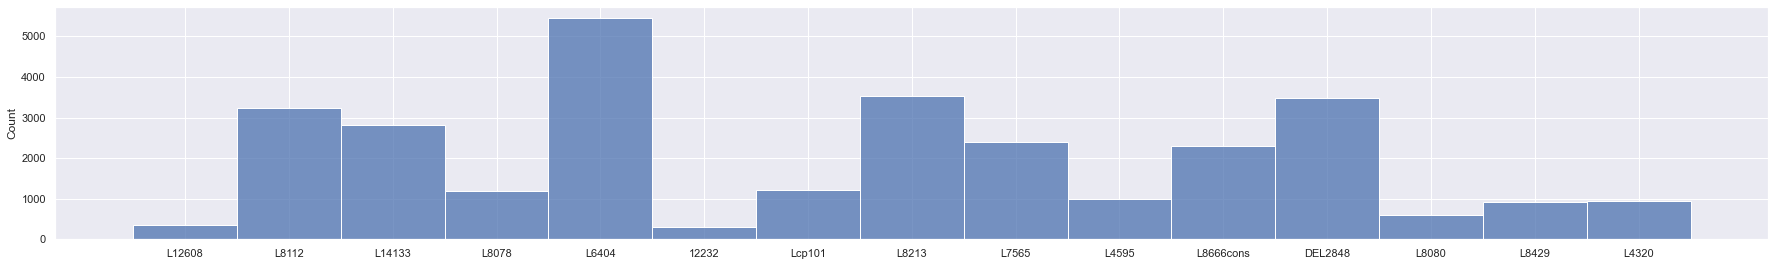

In [40]:
sns.set(rc={'figure.figsize':(30.7,4.27)})
sns.histplot(data=listaIdDocBase, discrete=True)

##### Setting dfTraning with third other document dataset

In [19]:
for dfTextProc in listaDfDocsOutros:
    txtList = dfTextProc["text_sentenca"].to_list()
    txt = ' '.join(txtList)
    
    ##Drop None
    txtList = [x for x in txtList if x is not None]

    reg = {  "cat":"outros"
             ,"text":txt
          }
        
    dfTreino = pd.concat([dfTreino,pd.DataFrame([reg])])
  

In [20]:
dfTreino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     5000 non-null   object
 1   text    5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [21]:

## Saving dataset
dfTreino.to_parquet(Path(os.path.join(BASE_DIR,'dataset', 'processed','dataset_treino_shufle_22082022.parquet')), engine='fastparquet')

In [22]:
dfTreino

,cat,text
0,terceiro_setor,O PROCESSAMENTO DAS COMPRAS E CONTRATAÇÕES POD...
0,terceiro_setor,"SEM PREJUÍZO DA AÇÃO QUE COUBER AO ASSOCIADO, ..."
0,terceiro_setor,A ORGANIZAÇÃO DA SOCIEDADE CIVIL DEVERÁ REGIST...
0,terceiro_setor,É VEDADA A CELEBRAÇÃO DE CONVÊNIOS E CONTRATOS...
0,terceiro_setor,SÃO CLÁUSULAS ESSENCIAIS DO TERMO DE PARCERIA:...
...,...,...
0,outros,O QUANDO A RESCISÃO OCORRER COM BASE NOS INCIS...
0,outros,O OCUPANTE DE CARGO EM COMISSÃO OU FUNÇÃO DE C...
0,outros,A ALOCAÇÃO DOS RISCOS CONTRATUAIS SERÁ QUANTIF...
0,outros,"O ENQUANTO NÃO EFETUADO O CANCELAMENTO, A AMOR..."


### Generating dataset withot shuffle sentences

In [23]:
dfTreino = dfSentencas[["cat","text_sentenca"]].copy()
dfTreino.columns = ["cat","text"]

In [24]:
dfTreino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7498 entries, 0 to 7497
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     7498 non-null   object
 1   text    7498 non-null   object
dtypes: object(2)
memory usage: 175.7+ KB


In [26]:
from transformers import  AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=True)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [30]:
dfTreino.columns

Index(['cat', 'text'], dtype='object')

In [35]:
dfTreino["tokenizer"] = dfTreino["text"].apply(lambda x: len(tokenizer.tokenize(x)))

In [42]:
dfTreino = dfTreino[dfTreino["tokenizer"] < 1000]

In [43]:
## Saving dataset
dfTreino.to_parquet(Path(os.path.join(BASE_DIR,'dataset', 'processed','dataset_treino_full_no_shuffle_22082022.parquet')), engine='fastparquet')

In [44]:
dfSentencasAll = pd.read_parquet(Path(os.path.join(BASE_DIR,'dataset', 'regbr','dados_regbr_sentencas.parquet')), engine='fastparquet')


In [46]:
dfSentencasAll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883635 entries, 0 to 883634
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id_sentenca          883635 non-null  object
 1   ordem                883635 non-null  int64 
 2   id_doc_base          883635 non-null  int64 
 3   tokens_total         883635 non-null  int64 
 4   tokens_no_stopwords  883635 non-null  int64 
 5   cat_sentenca         883635 non-null  int64 
 6   text_sentenca        883635 non-null  object
dtypes: int64(5), object(2)
memory usage: 47.2+ MB


In [50]:
dfSentencasAll = dfSentencasAll[dfSentencasAll["tokens_total"] < 1000]
dfSentencasAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881575 entries, 0 to 883634
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id_sentenca          881575 non-null  object
 1   ordem                881575 non-null  int64 
 2   id_doc_base          881575 non-null  int64 
 3   tokens_total         881575 non-null  int64 
 4   tokens_no_stopwords  881575 non-null  int64 
 5   cat_sentenca         881575 non-null  int64 
 6   text_sentenca        881575 non-null  object
dtypes: int64(5), object(2)
memory usage: 53.8+ MB


In [51]:
## Saving dataset
dfSentencasAll.to_parquet(Path(os.path.join(BASE_DIR,'dataset', 'regbr','dados_regbr_all_sentencas_22082022.parquet')), engine='fastparquet')